In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Turing
using ReverseDiff
using BenchmarkTools
using Turing
using ReverseDiff
# using FFTW

In [2]:
function fft!(x_re::AbstractVector{T}, x_im::AbstractVector{T}) where {T<:Any}
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    @inbounds for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return nothing
end
function fft!(A_re::AbstractMatrix{T}, A_im::AbstractMatrix{T}) where {T<:Any}
    Ny, Nx = size(A_re)
    @assert size(A_im) == (Ny, Nx) "Real and imaginary parts must have same dimensions"
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"

    # 1) FFT down each column
    @inbounds for x in 1:Nx
        # Get column views
        col_re = @view A_re[:, x]
        col_im = @view A_im[:, x]
        # In-place FFT on column
        fft!(col_re, col_im)
    end

    # 2) FFT across each row
    @inbounds for y in 1:Ny
        # Get row views
        row_re = @view A_re[y, :]
        row_im = @view A_im[y, :]
        # In-place FFT on row
        fft!(row_re, row_im)
    end
    
    return nothing
end
function fftshift!(x::AbstractArray, tmp::AbstractArray)
    # Calculate the shift amount for each dimension
    shifts = map(s -> div(s, 2), size(x))
    circshift!(tmp,x, shifts)
    # x = tmp    
    copyto!(x, tmp)
    return nothing
end

# Inverse operation
function ifftshift!(x::AbstractArray,tmp::AbstractArray)
    shifts = map(s -> -div(s, 2), size(x))
    circshift!(tmp, x, shifts)
    copyto!(x, tmp)
    # x = tmp
    return nothing
end

ifftshift! (generic function with 1 method)

In [3]:
function fft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

function ifft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

ifft (generic function with 1 method)

In [4]:
function fft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft(view(B, y, :))
    end
    return B
end

function ifft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = ifft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = ifft(view(B, y, :))
    end
    return B
end

ifft (generic function with 2 methods)

In [5]:
function custom_fftshift(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
function custom_fftshift(A::AbstractVector)
    n1 = length(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    return A[idx1]
end

function fftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(fft(custom_fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(ifft(custom_fftshift(B)))./(reduce(*,size(B)))
end

ifftnshift (generic function with 1 method)

In [6]:
function Wavelength(E::T)::T where T <: Real
    hc::T = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀::T = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end


function Focus(E::T, Cs::T, nᵢ=1)::T where T <: Real
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

Diff_Image(image, c=0.1) = @. log1p(c*abs(image))

Diff_Image (generic function with 2 methods)

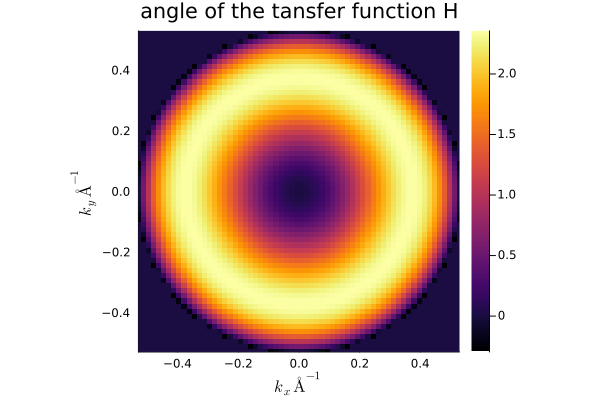

In [7]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^6
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = collect(lower:1:upper)
ky = collect(lower:1:upper)

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = collect(range(-L/2, L/2, N))
y = collect(range(-L/2, L/2, N))


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
H = @. exp(-1im*χ(k)*disk)*disk
# H = fill(1.0, N, N)
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

Free space evolution
\begin{align*}
    \psi(x,y,z) &= e^{ikz} \psi_0(x,y)*D(x,y,z)\\
    D(x,y,z) &= \frac{1}{i\lambda z} e^{i\frac{\pi}{\lambda z} ((x-x')^2 + (y-y')^2)}\\
    \psi(x,y,z) &= e^{ikz} \int dx'dy'\, \psi_0(x',y') \frac{1}{i\lambda z} e^{i\frac{\pi}{\lambda z} ((x-x')^2 + (y-y')^2)}\\
\end{align*}

The values that with be changing are 
\begin{align*}
    \Delta f_i, \quad C_{s,i}, \quad \Delta\vec{r}_{g2}, \quad \Delta E 
\end{align*}
where $i\in \{1,2,3\}$ for the three lenes; $\Delta\vec{r}$ represents the transverse misalignment of the second grating $g_2$; $\Delta E$ is the energy distribution of the imaged electrons. The transverse alignment of the first grating shouldn't matter since its fourier transform should be the same. 

For the next run of simulations, I will center the distribution of $\Delta f$ about zero. However, optimal alignment may have $\Delta f != 0$ e.g. scherzer's conditions in which the defocusing is set such that the minimum abberations are achieved.


Although I am incorporating abberations caused by misalignment, I am currently not including the possibility that the lens is off-centered, rendering alignment impossible/impractical. I may need to account for the fact the three lens may not be exactly between intermediate objects.

\begin{equation}
    \alpha_{max} = \left(\frac{6\lambda}{C_s} \right)^{1/4}
\end{equation}
$E ~ N(E_0, 0.4 eV )$

In [8]:
α_max = (6*λ(E)/Cs)^(1/4)
E_σ = 0.4/1000 #keV
α_sigma = (6*λ(E + E_σ)/Cs)^(1/4)

0.01042513153110659

In [9]:
err_abs = abs(α_max - α_sigma)
err_rel = err_abs/α_max
println("Maximum aberration: ", α_max, "  |  σ: ", α_sigma)
println("Absolute error: ", err_abs, "  |  Relative error: ", err_rel)

Maximum aberration: 0.010425133662921443  |  σ: 0.01042513153110659
Absolute error: 2.131814853117975e-9  |  Relative error: 2.0448801157342424e-7


This error is absurdly small. Furthermore, I checked the abs and rel err for the interaction parameter and it produced equally samll errs (both 1e-7). Therefore, the distribution of the energy speard will not be considered. However, the error of the center of the distribution, caused by miss reporting of the aperatus, may be contribute significantly. I should ask Kayla if she bayesian operimizes (BO) for the energy and/or the accelerating voltage. 

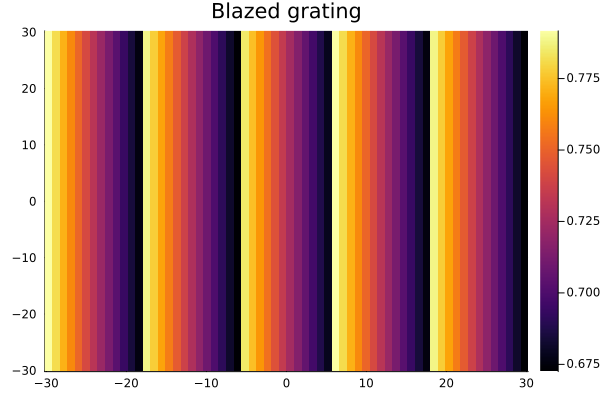

In [10]:
λ(E) = 12.398/sqrt(abs(E*(2*511 + E))) #Angstroms
σ(E::Real) = 2π/(λ(E)*E) * (511 + E)/(2*511 + E) # per Angstroms
function Si3N4_Grating_Parameters(E::T) where T <: Real
    #given from CJW thesis in units of per nm
    σU = 0.15 
    α = 0.008
    
    

    λ_nm = λ(E)/10 # convert to nm from Angstroms
    κ = α * (λ_nm/(2*π)) # this is the attenuation coefficient 

    # I assume that CJW uses 300 KeV for his values
    σ_cjw = σ(300) * 10 # per nm 
    U_mip = σU/σ_cjw 
    return (U_mip, κ)
end

function Blazed_Grating(p; N=N, mill_depth=208, thickness=500, E::Real=E)
    """
    Create a blazed grating transmission function for a given energy E.
    """
    
    U_mip, κ = Si3N4_Grating_Parameters(E)

    """
    creatings the 1D grating function (depth(x)), slopes upwards to the right
    """
    xs = collect(range(0, 1, length=N))
    d0 = thickness - mill_depth
    g_1d = @. mod(p*mill_depth*xs, mill_depth+1) + d0



    t_1d = @. cis((σ(E)*U_mip+1im*κ*2π/λ(E))*g_1d);
    t_2d = repeat(t_1d', N, 1)
    return t_2d
end


ρ2 = @. x'^2 + y^2
t1 = Blazed_Grating(5)
heatmap(x, y, abs.(t1), title="Blazed grating")

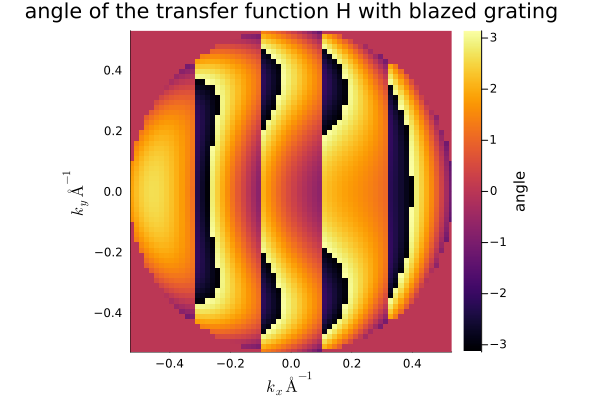

In [11]:
heatmap(kx,ky,angle.(t1.*H), aspect_ratio=1, xlims=(kx[1], kx[end]), ylims=(ky[1], ky[end]), 
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}",
        title="angle of the transfer function H with blazed grating",
        colorbar_title="angle")
        

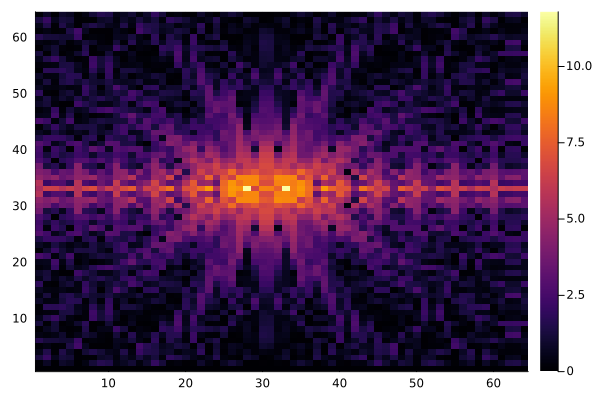

In [12]:
data = abs2.(fftnshift(t1.*H))
shift = 15
ctr = N÷2 + 1
mask = ctr-shift:ctr+shift, ctr-shift:ctr+shift
heatmap(Diff_Image(data))

In [307]:
using PreallocationTools: DiffCache, get_tmp
@model function single_propagation(y::AbstractMatrix{<:AbstractFloat}, 
                                    params::Vector{<:AbstractFloat},
                                    arrs::Vector{<:Matrix{<:AbstractFloat}},
                                    disk::BitMatrix,
                                    caches::Vector{<:DiffCache})
    Cs_ctr, E_ctr, Δf_ctr, Cs_σ, E_σ, Δf_σ = params
    t1r, t1i, k = arrs

    Cs ~ Normal(Cs_ctr, Cs_σ)
    E ~ Normal(E_ctr, E_σ)
    Δf ~ Normal(Δf_ctr, Δf_σ)

    Hr, Hi = get_tmp(caches[1],E), get_tmp(caches[2],E)
    abberations = get_tmp(caches[3],E)
    
    prodr = get_tmp(caches[4],E)
    prodi = get_tmp(caches[5],E)
    buff = get_tmp(caches[6],E)




    # @. abberations = π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf) * disk 
    # @. H = cis(-abberations)*disk
    @inbounds for i in eachindex(k)
        abberations[i] = π*λ(E)*k[i]^2*(0.5*Cs*λ(E)^2*k[i]^2 - Δf) * disk[i]
        Hi[i], Hr[i] = sincos(-abberations[i])
        Hi[i], Hr[i] = Hi[i]*disk[i], Hr[i]*disk[i]


        prodr[i] = t1r[i] * Hr[i] - t1i[i] * Hi[i]
        prodi[i] = t1r[i] * Hi[i] + t1i[i] * Hr[i]
    end
    
    fftshift!(prodr, buff)
    fftshift!(prodi, buff)
    fft!(prodr, prodi)
    fftshift!(prodr, buff)
    fftshift!(prodi, buff)
    
    # @. H = abs2($fftnshift(abberations))


    # χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
    # H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
    # H = @. exp(-1im*χ(k)*disk)*disk
    @inbounds @simd for i in eachindex(k)
        buff[i] = prodr[i]^2 + prodi[i]^2
        Turing.@addlogprob! -(y[i] - buff[i])^2 
    end
end

single_propagation (generic function with 2 methods)

In [13]:
Δf(E, Cs)

543.4170594488893

In [308]:
stds = [5*1e6, 3, 1e2]
params0 = [Cs+1e6, E+2.0, Δf(E, Cs)-2*1e1]
params = [params0..., stds...];
println("Parameters: ", params)

t1_real, t1_imag = real.(t1), imag.(t1)
arrs = [t1_real, t1_imag, k]
caches = [DiffCache(zeros(size(k))) for _ in 1:6]
# cache = DiffCache(zeros(size(t1)))
# cache2 = DiffCache(zeros(Float64, size(t1)))

model = single_propagation(data, params, arrs, disk, caches);

Parameters: [1.1e7, 302.0, 523.4170594488893, 5.0e6, 3.0, 100.0]


In [ ]:
t1r, t1i, k = arrs
Hr, Hi = get_tmp(caches[1],E), get_tmp(caches[2],E)
abberations = get_tmp(caches[3],E)

prodr = get_tmp(caches[4],E)
prodi = get_tmp(caches[5],E)
buff = get_tmp(caches[6],E)




# @. abberations = π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf) * disk 
# @. H = cis(-abberations)*disk
@inbounds for i in eachindex(k)
    abberations[i] = π*λ(E)*k[i]^2*(0.5*Cs*λ(E)^2*k[i]^2 - Δf(E, Cs)) * disk[i]
    Hi[i], Hr[i] = sincos(-abberations[i])
    Hi[i], Hr[i] = Hi[i]*disk[i], Hr[i]*disk[i]


    prodr[i] = t1r[i] * Hr[i] - t1i[i] * Hi[i]
    prodi[i] = t1r[i] * Hi[i] + t1i[i] * Hr[i]
end

fftshift!(prodr, buff)
fftshift!(prodi, buff)
fft!(prodr, prodi)
fftshift!(prodr, buff)
fftshift!(prodi, buff)

# @. H = abs2($fftnshift(abberations))


# χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
# H = @. exp(-1im*χ(k)*disk)*disk

@inbounds @simd for i in eachindex(k)
    buff[i] = prodr[i]^2 + prodi[i]^2
    # buff[i] = atan(prodi[i], prodr[i]) # angle
    Turing.@addlogprob! -(y[i] - buff[i])^2 
end

everything up to the point before buff for some reason. I am testing that everythnig is correct without the fft. for some reason $prodi.^2 .+ prodr.^2$ is different if i pull it straight from buff

In [318]:
using AdvancedHMC
n_adapts = 4_000
n_samples = n_adapts + 0
n_chains = 8

δ_target = 0.65
ϵ0 = 0.9
D = 3
metric = DenseEuclideanMetric(D)
# kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), ClassicNoUTurn(max_depth=7)))
kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), GeneralisedNoUTurn(max_depth=9)))
mma = MassMatrixAdaptor(metric)
ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
adaptor = StanHMCAdaptor(mma, ssa)
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts = externalsampler(hmcsampler)
initial_params = params0
initial_params = [params0 .+ clamp.(randn(3),-1.,1.).*stds for _ in 1:n_chains]


8-element Vector{Vector{Float64}}:
 [1.3798505947756719e7, 304.34054600375055, 423.4170594488893]
 [6.0e6, 300.26658647214003, 623.4170594488893]
 [1.584515209477486e7, 301.42347593545685, 482.650527030717]
 [6.0e6, 305.0, 468.1457055311924]
 [1.5455615946296904e7, 305.0, 598.9774376995186]
 [1.6e7, 302.93528329753536, 623.4170594488893]
 [8.141965964570415e6, 305.0, 423.4170594488893]
 [8.101654277151062e6, 299.0, 561.0645808443054]

In [319]:
best_params = []
best_lp = -Inf
best_res = []
for init_params in initial_params
    res = Turing.Optimisation.maximum_a_posteriori(model; initial_params=init_params)
    println("MAP estimate: ", res, " with logprob: ", res.lp)
    if res.lp > best_lp
        best_lp = res.lp
        best_params = res.values.array
        best_res = res
    end
end
println(params0)
println(stds)
println("Best MAP estimate: ", best_params, " with logprob: ", best_lp)
initial_params = [best_params for _ in 1:n_chains];

MAP estimate: [1.6812524358483702e7, 294.44483662593035, 640.3110950433977] with logprob: -1.2940103821227314e12
MAP estimate: [8.299109650113529e6, 270.8999014682194, 510.6739801642494] with logprob: -77.85578418075504
MAP estimate: [1.5845152093478048e7, 285.0692286605661, 627.7868056840653] with logprob: -1.2940103821351365e12
MAP estimate: [8.256099206680331e6, 270.1250012366737, 509.79030363707477] with logprob: -80.49076510914546
MAP estimate: [-6.469179599109767e6, -1258.1071238479904, -469.2482585228203] with logprob: -4.4178839236526084e8
MAP estimate: [1.7558148395973463e7, 301.47693438829106, 649.6402882895927] with logprob: -1.2940103821198677e12
MAP estimate: [1.0056474374354018e7, 300.9191928497173, 544.4381270120598] with logprob: -23.99214747520114
MAP estimate: [1.0014482551826112e7, 300.2359875962524, 543.6792719700328] with logprob: -24.09900207580747
[1.1e7, 302.0, 523.4170594488893]
[5.0e6, 3.0, 100.0]
Best MAP estimate: [1.0056474374354018e7, 300.9191928497173, 54

In [311]:
dump(best_res)

Turing.Optimisation.ModeResult{NamedArrays.NamedVector{Float64, Vector{Float64}, Tuple{OrderedDict{Symbol, Int64}}}, SciMLBase.OptimizationSolution{Float64, 1, Vector{Float64}, OptimizationBase.OptimizationCache{SciMLBase.OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, Turing.Optimisation.OptimLogDensity{DynamicPPL.Model{typeof(single_propagation), (:y, :params, :arrs, :disk, :caches), (), (), Tuple{Matrix{Float64}, Vector{Float64}, Vector{Matrix{Float64}}, BitMatrix, Vector{DiffCache{Matrix{Float64}, Vector{Float64}}}}, Tuple{}, DynamicPPL.DefaultContext}, DynamicPPL.TypedVarInfo{@NamedTuple{Cs::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:Cs, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:Cs, typeof(identity)}}, Vector{Float64}}, E::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:E, typeof(identity)}, Int64}, Vector{Normal{Float64}}, Vector{AbstractPPL.VarName{:E, typeof(identity)}}, Vector{Float64}}, Δf::DynamicPPL.Metadata{Dict{Abstract

In [200]:
@benchmark sample(model,nuts,
                    MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=false, 
                    n_adapts=n_adapts, 
                    initial_params=initial_params,
                    save_state=true, 
                    adtype = AutoForwardDiff())

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 126.648 s (3.44% GC) to evaluate,
 with a memory estimate of 30.31 GiB, over 472004014 allocations.

In [199]:


@benchmark sample(model,nuts,
                    MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=false, 
                    n_adapts=n_adapts, 
                    initial_params=initial_params,
                    save_state=true, 
                    adtype = AutoReverseDiff(true))

BenchmarkTools.Trial: 1 sample with 1 evaluation per sample.
 Single result which took 93.055 s (4.49% GC) to evaluate,
 with a memory estimate of 29.73 GiB, over 463334074 allocations.

In [320]:
chain = sample(model,nuts,
                    MCMCThreads(), 
                    n_samples, n_chains; 
                    progress=true, 
                    n_adapts=n_adapts, 
                    initial_params=initial_params,
                    save_state=true, 
                    adtype = AutoForwardDiff())

Sampling (8 threads)   0%|                              |  ETA: N/A
Sampling (8 threads)  12%|███▊                          |  ETA: 0:57:48
Sampling (8 threads)  25%|███████▌                      |  ETA: 0:24:46
Sampling (8 threads)  38%|███████████▎                  |  ETA: 0:13:46
Sampling (8 threads)  50%|███████████████               |  ETA: 0:08:15
Sampling (8 threads)  62%|██████████████████▊           |  ETA: 0:04:57
Sampling (8 threads)  75%|██████████████████████▌       |  ETA: 0:02:45
Sampling (8 threads)  88%|██████████████████████████▎   |  ETA: 0:01:11
Sampling (8 threads) 100%|██████████████████████████████| Time: 0:08:19
Sampling (8 threads) 100%|██████████████████████████████| Time: 0:08:19


Chains MCMC chain (4000×16×8 Array{Float64, 3}):

Iterations        = 1:1:4000
Number of chains  = 8
Samples per chain = 4000
Wall duration     = 499.68 seconds
Compute duration  = 3927.16 seconds
parameters        = Cs, E, Δf
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters            mean          std        mcse   ess_bulk   ess_tail    ⋯
      Symbol         Float64      Float64     Float64    Float64    Float64    ⋯

          Cs   10079104.2335   79993.1055   8285.6686   100.4968   111.1770    ⋯
           E        301.2840       1.2943      0.1340   100.5323   111.1770    ⋯
          Δf        544.8424       1.4356      0.1486   100.5848   111.1770    ⋯
                                                               2 columns omitted

Quantiles
  parameters           2.5%           25.

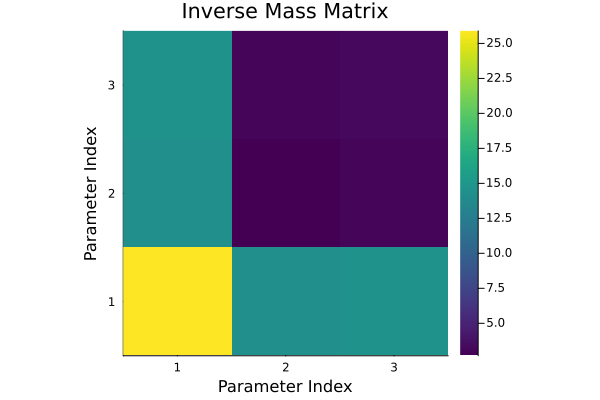

In [151]:
heatmap(log1p.(inv_mass_metric), 
aspect_ratio=:equal, color=:viridis,
title="Inverse Mass Matrix",
xlabel="Parameter Index",
ylabel="Parameter Index",
xticks=(1:D, 1:D),
yticks=(1:D, 1:D),
xlims=(0.5, D+0.5),
ylims=(0.5, D+0.5))

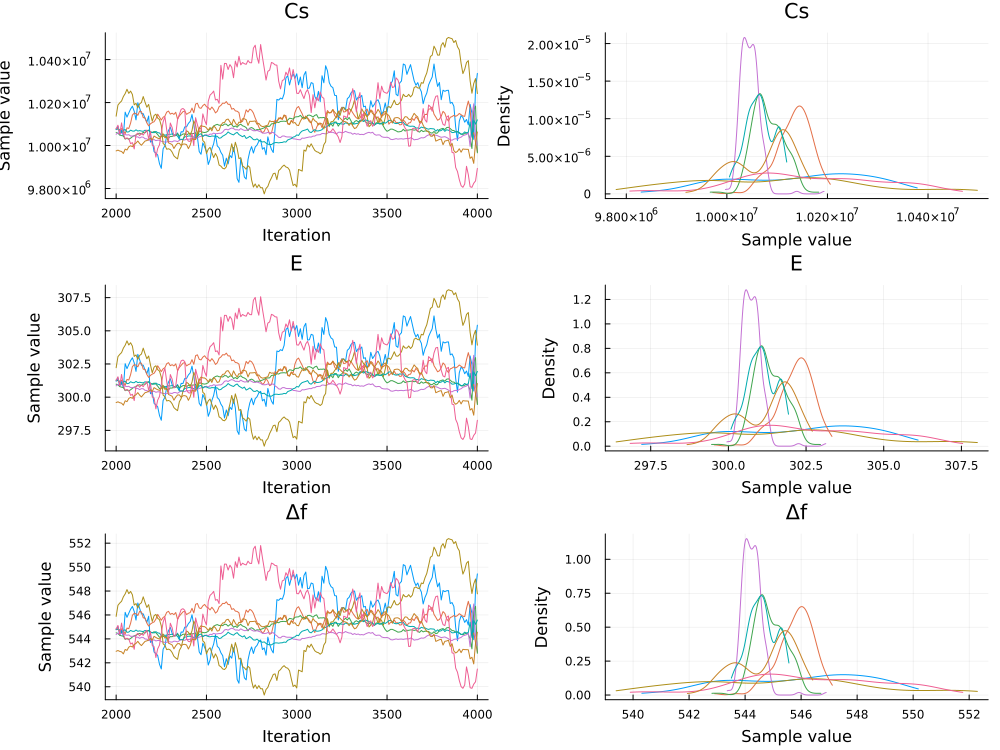

In [321]:
thinning = 10
using StatsPlots
plot(chain[end÷2:thinning:end,:,:])

lets taylor expand z abound f. $z>>\rho>>\lambda$, the exponent is much less than 1 given the fresnel condition
\begin{align*}
    \exp\left[{i\frac{\pi}{\lambda z} (x^2+y^2)}\right] &= \exp\left[i\frac{\pi}{\lambda} (x^2+y^2)(\frac{1}{f} - \frac{1}{f^2}\Delta z)\right]
\end{align*}

In [144]:
dump(best_params)

Array{Float64}((3,)) [1.0122929406759271e7, 301.9973126989771, 545.6347280789788]


In [324]:
chain = chain2

Chains MCMC chain (1000×16×8 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 8
Samples per chain = 1000
Wall duration     = 132.05 seconds
Compute duration  = 974.85 seconds
parameters        = Cs, E, Δf
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters            mean          std        mcse   ess_bulk   ess_tail    ⋯
      Symbol         Float64      Float64     Float64    Float64    Float64    ⋯

          Cs   10130803.2096   89105.1137   3082.6177   739.5433   646.8015    ⋯
           E        302.1214       1.4423      0.0499   739.5510   646.8015    ⋯
          Δf        545.7715       1.5999      0.0553   739.5699   648.1273    ⋯
                                                               2 columns omitted

Quantiles
  parameters           2.5%           25.0

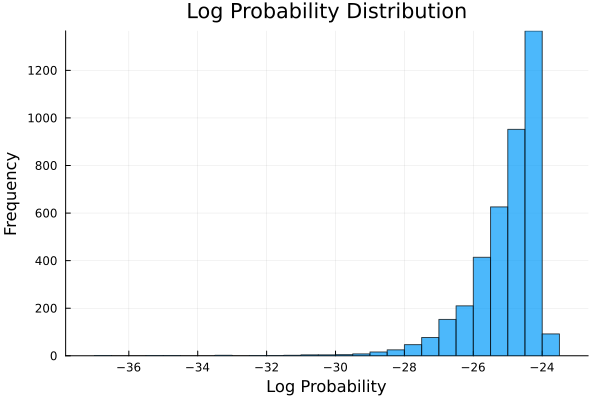

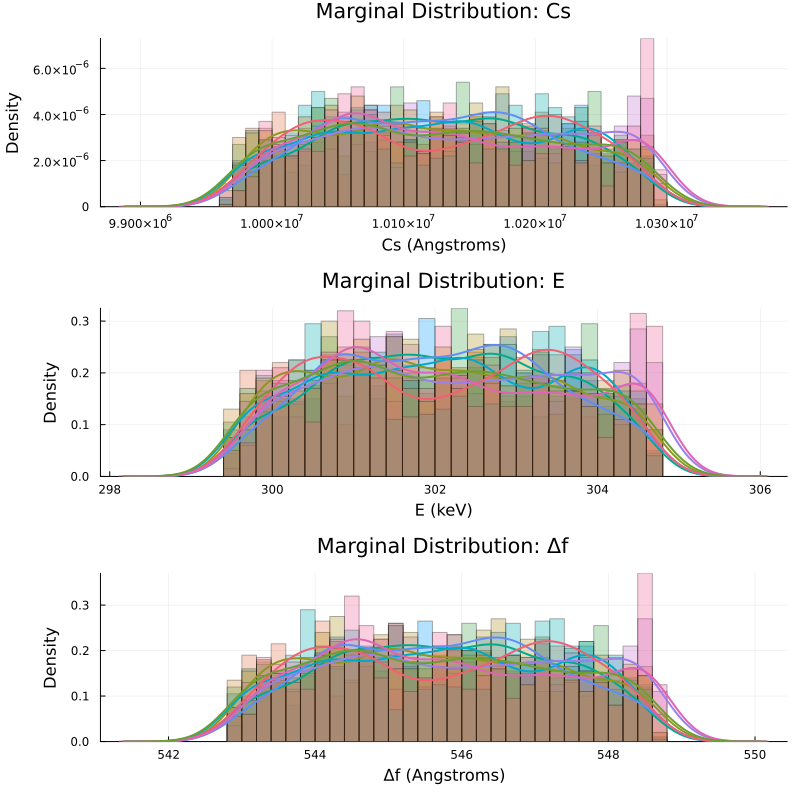

In [326]:
using StatsPlots


logprobs = logjoint(model, chain[end÷2:end,:,:])

lp_plot = histogram(vec(logprobs), 
            title="Log Probability Distribution", 
            xlabel="Log Probability", 
            ylabel="Frequency",
            legend=false,
            alpha=0.7,
            bins=30)
display(lp_plot)

burnin = 0 + 1

# For Cs parameter
p1 = histogram(chain[burnin:end, :Cs, :], 
              title="Marginal Distribution: Cs", 
              xlabel="Cs (Angstroms)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p1, chain[burnin:end, :Cs, :], linewidth=2)

# For E parameter
p2 = histogram(chain[burnin:end, :E, :], 
              title="Marginal Distribution: E", 
              xlabel="E (keV)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p2, chain[burnin:end, :E, :], linewidth=2)

# For Δf parameter
p3 = histogram(chain[burnin:end, :Δf, :], 
              title="Marginal Distribution: Δf", 
              xlabel="Δf (Angstroms)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p3, chain[burnin:end, :Δf, :], linewidth=2)

# Combine all marginal plots
marginal_plot = plot(p1, p2, p3, layout=(3,1), size=(800, 800))
display(marginal_plot)

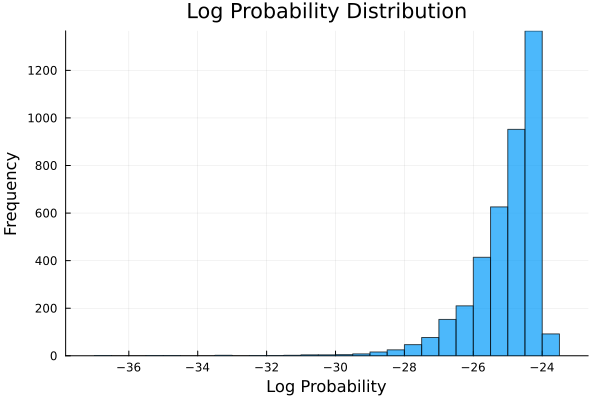

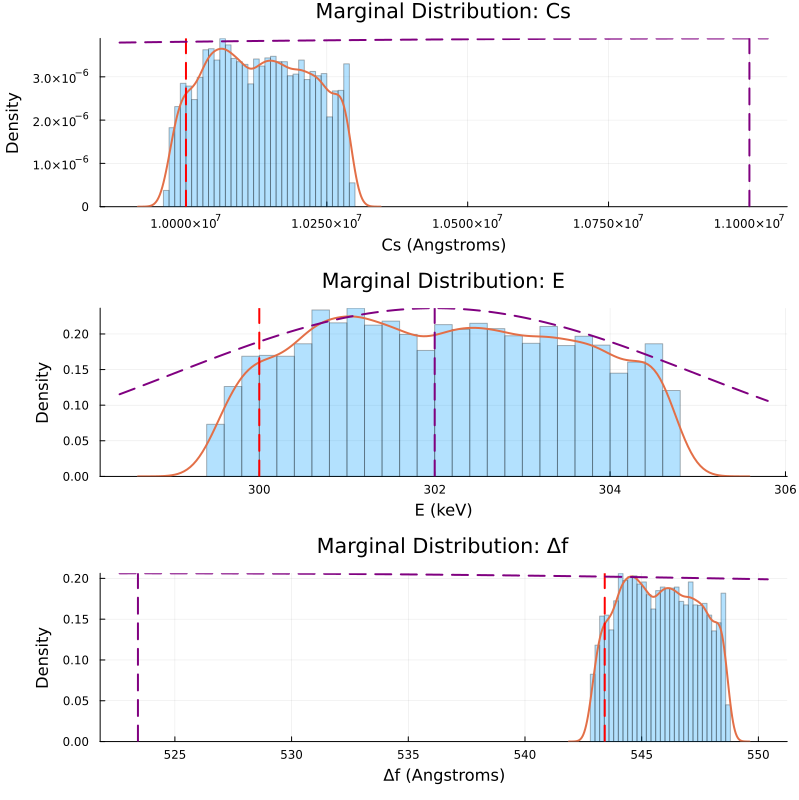

In [327]:
using StatsPlots

# # 1. Histogram of log probability values
# if haskey(chain, :lp)
#     lp_plot = histogram(chain[:lp], 
#               title="Log Probability Distribution", 
#               xlabel="Log Probability", 
#               ylabel="Frequency",
#               legend=false,
#               alpha=0.7,
#               bins=30)
#     display(lp_plot)
# else
# Alternative approach to extract log probabilities
logprobs = logjoint(model, chain[end÷2:end,:,:])

lp_plot = histogram(vec(logprobs), 
            title="Log Probability Distribution", 
            xlabel="Log Probability", 
            ylabel="Frequency",
            legend=false,
            alpha=0.7,
            bins=30)
display(lp_plot)
# end

# 2. Marginal distributions (post burn-in period)
burnin = size(chain)[1] ÷ 2  # Use second half of chain
burnin = 1  # Use second half of chain

# For Cs parameter
p1 = histogram(vec(chain[burnin:end, :Cs, :]), 
              title="Marginal Distribution: Cs", 
              xlabel="Cs (Angstroms)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p1, vec(chain[burnin:end, :Cs, :]), linewidth=2)
vline!(p1, [Cs], label="True value", linestyle=:dash, linewidth=2, color=:red)
vline!(p1, [params0[1]], label="True value", linestyle=:dash, linewidth=2, color=:purple)
xmin, xmax = xlims(p1)
ymin, ymax = ylims(p1)
param_prior = pdf.(Normal(params0[1], stds[1]), collect(range(xmin, xmax, length=100))) 
param_prior *= ymax / maximum(param_prior)  # Normalize to density
plot!(p1, collect(range(xmin, xmax, length=100)), param_prior,
        label="Prior", color=:purple, linewidth=2, linestyle=:dash)


# For E parameter
p2 = histogram(vec(chain[burnin:end, :E, :]), 
              title="Marginal Distribution: E", 
              xlabel="E (keV)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p2, vec(chain[burnin:end, :E, :]), linewidth=2)
vline!(p2, [E], label="True value", linestyle=:dash, linewidth=2, color=:red)
vline!(p2, [params0[2]], label="True value", linestyle=:dash, linewidth=2, color=:purple)
xmin, xmax = xlims(p2)
ymin, ymax = ylims(p2)
param_prior = pdf.(Normal(params0[2], stds[2]), collect(range(xmin, xmax, length=100))) 
param_prior *= ymax / maximum(param_prior)  # Normalize to density
plot!(p2, collect(range(xmin, xmax, length=100)), param_prior,
        label="Prior", color=:purple, linewidth=2, linestyle=:dash)

# For Δf parameter
p3 = histogram(vec(chain[burnin:end, :Δf, :]), 
              title="Marginal Distribution: Δf", 
              xlabel="Δf (Angstroms)", 
              ylabel="Density",
              legend=false,
              normalize=true,
              alpha=0.3,
              bins=30)
density!(p3, vec(chain[burnin:end, :Δf, :]), linewidth=2)
vline!(p3, [Δf(E,Cs)], label="True value", linestyle=:dash, linewidth=2, color=:red)
vline!(p3, [params0[3]], label="True value", linestyle=:dash, linewidth=2, color=:purple)
xmin, xmax = xlims(p3)
ymin, ymax = ylims(p3)
param_prior = pdf.(Normal(params0[3], stds[3]), collect(range(xmin, xmax, length=100))) 
param_prior *= ymax / maximum(param_prior)  # Normalize to density
plot!(p3, collect(range(xmin, xmax, length=100)), param_prior,
        label="Prior", color=:purple, linewidth=2, linestyle=:dash)

# Combine all marginal plots
marginal_plot = plot(p1, p2, p3, layout=(3,1), size=(800, 800))
display(marginal_plot)

# # Combined plot of all chains' traces with densities
# combined_plot = corner(chain[burnin:end, [:Cs, :E, :Δf], :])
# display(combined_plot)

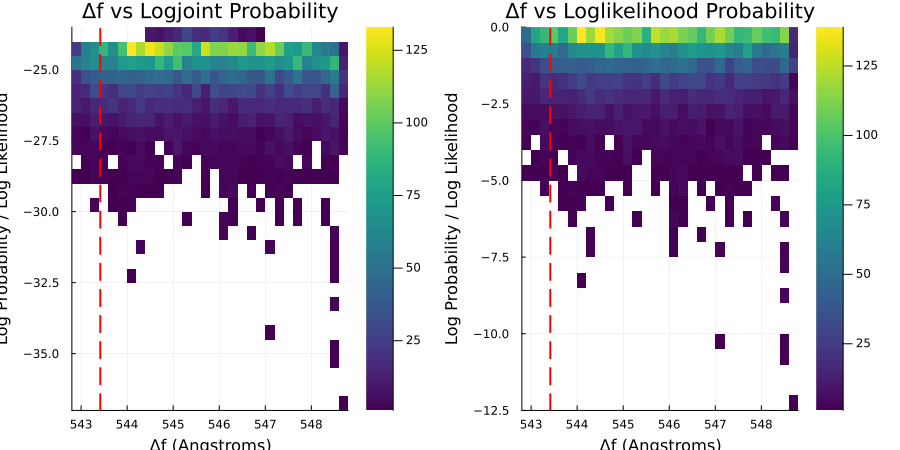

In [328]:
using KernelDensity

# Extract the values and corresponding log probabilities
param_values = vec(chain[burnin:end, :Δf, :])
log_probs = vec(logjoint(model, chain[burnin:end, :, :]))
loglikelihood_probs = vec(loglikelihood(model, chain[burnin:end, :, :]))

# Create a KDE function for the y-coordinates
using KernelDensity
kde_func = kde(param_values)
# Create a 2D histogram/heatmap
fig1 = histogram2d(param_values, log_probs,
            nbins=30,
            color=:viridis,
            xlabel="Δf (Angstroms)",
            ylabel="Log Probability",
            title="Δf vs Logjoint Probability")

# Add a vertical line for the true value
vline!(fig1, [Δf(E,Cs)], color=:red, linestyle=:dash, linewidth=2)

fig2 = histogram2d(param_values, loglikelihood_probs,
            nbins=30,
            color=:viridis,
            xlabel="Δf (Angstroms)",
            ylabel="Log Probability",
            title="Δf vs Loglikelihood Probability")

# Add a vertical line for the true value
vline!(fig2, [Δf(E,Cs)], color=:red, linestyle=:dash, linewidth=2)

plot(fig1, fig2, layout=(1,2), size=(900, 450),
      # title="",
      xlabel="Δf (Angstroms)", ylabel="Log Probability / Log Likelihood",
      label="")    # Extra space for y-axis label

Posterior Covariance Matrix:

Fisher Information Matrix:

Parameter standard errors:
Cs: 160219.71183688962
E: 2.5928592314343435
Δf: 2.8761669226006497


3×3 Matrix{Float64}:
 2.56704e10  4.15422e5  4.6081e5
 4.15422e5   6.72292    7.45748
 4.6081e5    7.45748    8.27234

3×3 Matrix{Float64}:
  2.16147e-6      -0.279775       0.131811
 -0.279775     67427.9       -45201.2
  0.131811    -45201.2        33406.3

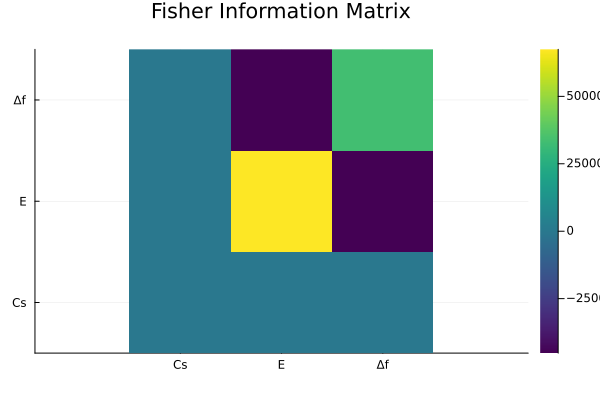

In [299]:
using LinearAlgebra

# Extract all parameter samples from chain
burnin = size(chain)[1] ÷ 2  # Use second half of chain
samples = Array{Float64}(undef, 0, 3)

# Combine samples from all chains
for i in burnin:size(chain)[1]
    for c in 1:size(chain)[3]  # Loop through chains
        # Get Cs, E, and Δf values
        row = [chain[i, :Cs, c], chain[i, :E, c], chain[i, :Δf, c]]
        samples = vcat(samples, row')
    end
end

# Compute posterior covariance matrix
posterior_cov = cov(samples)
println("Posterior Covariance Matrix:")
display(posterior_cov)

# Fisher Information Matrix is inverse of covariance matrix
fisher_info = inv(posterior_cov)
println("\nFisher Information Matrix:")
display(fisher_info)

# Calculate parameter uncertainties (standard errors)
std_errors = sqrt.(diag(posterior_cov))
println("\nParameter standard errors:")
println("Cs: ", std_errors[1])
println("E: ", std_errors[2])
println("Δf: ", std_errors[3])

# Visualize the Fisher Information Matrix
using Plots
heatmap(fisher_info, 
        title="Fisher Information Matrix",
        color=:viridis,
        xticks=(1:3, ["Cs", "E", "Δf"]),
        yticks=(1:3, ["Cs", "E", "Δf"]),
        aspect_ratio=:equal)

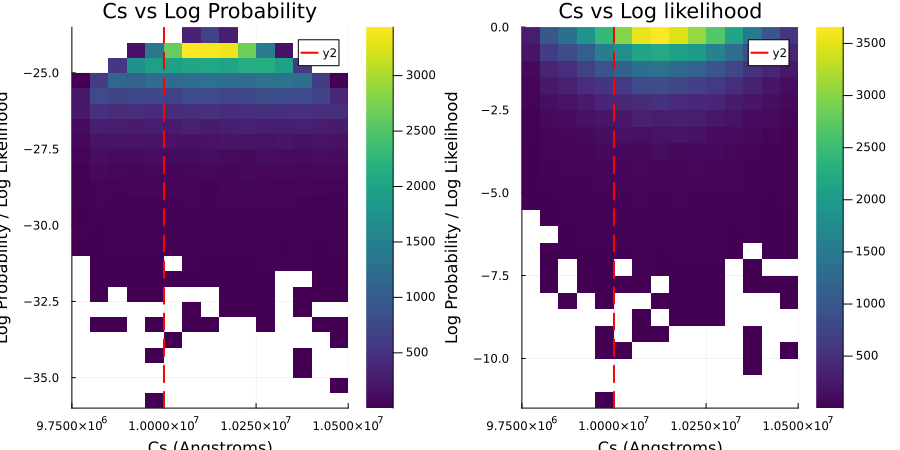

In [297]:
# Extract the values and corresponding log probabilities
param_values = vec(chain[burnin:end, :Cs, :])
log_probs = vec(logjoint(model, chain[burnin:end, :, :]))
log_likelihoods = vec(loglikelihood(model, chain[burnin:end, :, :]))

# Create a KDE function for the y-coordinates
using KernelDensity
kde_func = kde(param_values)
# Create a 2D histogram/heatmap
fig1 = histogram2d(param_values, log_probs,
            nbins=30,
            color=:viridis,
            xlabel="Cs (Angstroms)",
            ylabel="Logjoint Probability",
            title="Cs vs Log Probability")

# Add a vertical line for the true value
vline!(fig1, [Cs], color=:red, linestyle=:dash, linewidth=2)

fig2 = histogram2d(param_values, log_likelihoods,
            nbins=30,
            color=:viridis,
            xlabel="Cs (Angstroms)",
            ylabel="Loglikelihood Probability",
            title="Cs vs Log likelihood")

# Add a vertical line for the true value
vline!(fig2, [Cs], color=:red, linestyle=:dash, linewidth=2)
plot(fig1, fig2, layout=(1,2), size=(900, 450),
      # title="Cs vs Log joint ProbLikelihood",
      xlabel="Cs (Angstroms)", ylabel="Log Probability / Log Likelihood")    # Extra space for y-axis label

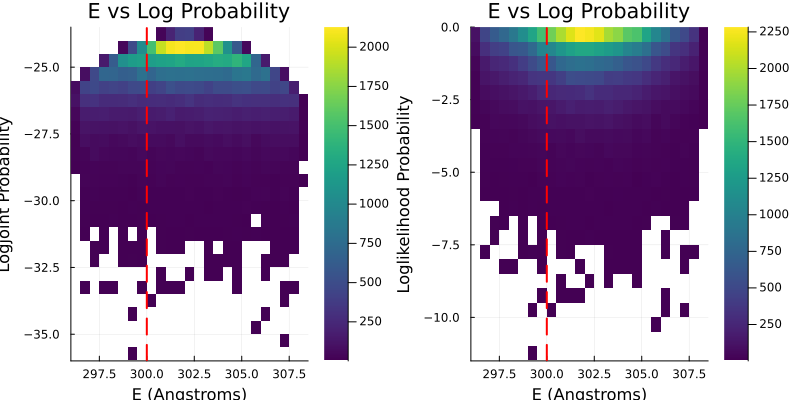

In [298]:
# Extract the values and corresponding log probabilities
param_values = vec(chain[burnin:end, :E, :])
log_probs = vec(logjoint(model, chain[burnin:end, :, :]))
loglikelihood_probs = vec(loglikelihood(model, chain[burnin:end, :, :]))

# Create a KDE function for the y-coordinates
using KernelDensity
kde_func = kde(param_values)
# Create a 2D histogram/heatmap
fig1 = histogram2d(param_values, log_probs,
            nbins=30,
            color=:viridis,
            xlabel="E (Angstroms)",
            ylabel="Logjoint Probability",
            title="E vs Log Probability")

# Add a vertical line for the true value
vline!(fig1, [E], color=:red, linestyle=:dash, linewidth=2)

fig2 = histogram2d(param_values, loglikelihood_probs,
            nbins=30,
            color=:viridis,
            xlabel="E (Angstroms)",
            ylabel="Loglikelihood Probability",
            title="E vs Log Probability")

# Add a vertical line for the true value
vline!(fig2, [E], color=:red, linestyle=:dash, linewidth=2)
# vline!(fig2, [params0[2]], label="", linestyle=:dash, linewidth=2, color=:purple)

plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

In [322]:
ϵ0 = chain.info.samplerstate.state.κ.τ.integrator.ϵ
println("ϵ0: ", ϵ0)
δ_target = 0.65
inv_mass_metric = chain.info.samplerstate.state.metric.M⁻¹
metric = DenseEuclideanMetric(inv_mass_metric)

kernel = HMCKernel(Trajectory{MultinomialTS}(Leapfrog(ϵ0), GeneralisedNoUTurn(max_depth=9)))
# ssa = StepSizeAdaptor(δ_target, Leapfrog(ϵ0))
adaptor = NoAdaptation()
hmcsampler = AdvancedHMC.HMCSampler(kernel, metric, adaptor)  
nuts2 = externalsampler(hmcsampler)
more_draws = 1_000
last_draw = [vec(chain[end, [:Cs, :E, :Δf], i].value.data) for i in 1:n_chains]
chain2 = sample(model,
                nuts2,  # reuse the tuned NUTS object
                MCMCThreads(),
                more_draws,
                n_chains;
                save_state = true, 
                initial_params = initial_params,  # continue from the last state
                # init_params = chain[end,1:3,:].value.data,
                # initial_params = [1.0,2.0,1.0],  # continue from the last state
                # resume_from = chain,  # continue from the last state
                n_adapts   = 0, 
                adtype=AutoReverseDiff(true))  # turn adaptation off

ϵ0: 0.0034078823141336255


Sampling (8 threads)   0%|                              |  ETA: N/A
Sampling (8 threads)  12%|███▊                          |  ETA: 0:15:24
Sampling (8 threads)  25%|███████▌                      |  ETA: 0:06:36
Sampling (8 threads)  38%|███████████▎                  |  ETA: 0:03:40
Sampling (8 threads)  50%|███████████████               |  ETA: 0:02:12
Sampling (8 threads)  62%|██████████████████▊           |  ETA: 0:01:19
Sampling (8 threads)  75%|██████████████████████▌       |  ETA: 0:00:44
Sampling (8 threads)  88%|██████████████████████████▎   |  ETA: 0:00:19
Sampling (8 threads) 100%|██████████████████████████████| Time: 0:02:12
Sampling (8 threads) 100%|██████████████████████████████| Time: 0:02:12


Chains MCMC chain (1000×16×8 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 8
Samples per chain = 1000
Wall duration     = 132.05 seconds
Compute duration  = 974.85 seconds
parameters        = Cs, E, Δf
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters            mean          std        mcse   ess_bulk   ess_tail    ⋯
      Symbol         Float64      Float64     Float64    Float64    Float64    ⋯

          Cs   10130803.2096   89105.1137   3082.6177   739.5433   646.8015    ⋯
           E        302.1214       1.4423      0.0499   739.5510   646.8015    ⋯
          Δf        545.7715       1.5999      0.0553   739.5699   648.1273    ⋯
                                                               2 columns omitted

Quantiles
  parameters           2.5%           25.0

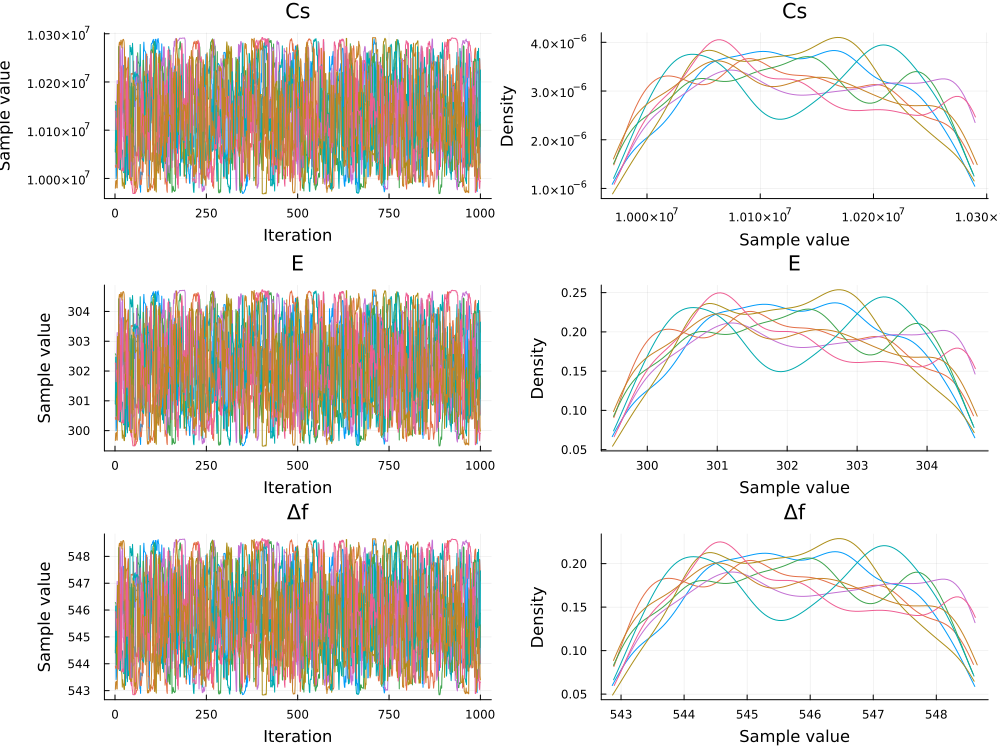

In [323]:
thinning = 1
using StatsPlots
plot(chain2[1:thinning:end,:,:])

\begin{align*}
    &2N^2\ln(N)\\
    &2(2N)^2\ln(2N)\\
    &= 8N^2(\ln(N) + \ln(2))\\
\end{align*}

In [338]:
println(2*32^2*log(32))
println(8*32^2*log(2*32)/10)

7097.82712893384
3406.9570218882427


In [243]:
ϵ0 = chain.info.samplerstate.state.κ.τ.integrator.ϵ
println("ϵ0: ", ϵ0)
inv_mass_metric = chain.info.samplerstate.state.metric.M⁻¹

ϵ0: 0.23582385914301182


3×3 Matrix{Float64}:
     2.71186e9  43837.0       48611.3
 43837.0            0.70863       0.785803
 48611.3            0.785803      0.871413

In [249]:
using PreallocationTools: DiffCache, get_tmp
@model function single_propagation_pigeons(y::AbstractMatrix{<:AbstractFloat}, 
                                    params::Vector{<:AbstractFloat},
                                    arrs::Vector{<:Matrix{<:AbstractFloat}},
                                    disk::BitMatrix,
                                    caches::Vector{<:DiffCache})
    Cs_ctr, E_ctr, Δf_ctr, Cs_σ, E_σ, Δf_σ = params
    t1r, t1i, k = arrs

    # σ ~ Exponential(1)
    Cs ~ Normal(Cs_ctr, Cs_σ)
    # E ~ truncated(Normal(E_ctr, E_σ),lower=0.1)
    E ~ Normal(E_ctr, E_σ)

    # log_E ~ Normal(log(E_ctr), E_σ/E_ctr)
    # E = exp(log_E)  # Always positive
    Δf ~ Normal(Δf_ctr, Δf_σ)

    Hr, Hi = get_tmp(caches[1],E), get_tmp(caches[2],E)
    abberations = get_tmp(caches[3],E)
    
    prodr = get_tmp(caches[4],E)
    prodi = get_tmp(caches[5],E)
    buff = get_tmp(caches[6],E)




    # @. abberations = π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf) * disk 
    # @. H = cis(-abberations)*disk
    @inbounds for i in eachindex(k)
        abberations[i] = π*λ(E)*k[i]^2*(0.5*Cs*λ(E)^2*k[i]^2 - Δf) * disk[i]
        Hi[i], Hr[i] = sincos(-abberations[i])
        Hi[i], Hr[i] = Hi[i]*disk[i], Hr[i]*disk[i]


        prodr[i] = t1r[i] * Hr[i] - t1i[i] * Hi[i]
        prodi[i] = t1r[i] * Hi[i] + t1i[i] * Hr[i]
    end
    
    fftshift!(prodr, buff)
    fftshift!(prodi, buff)
    fft!(prodr, prodi)
    fftshift!(prodr, buff)
    fftshift!(prodi, buff)
    
    # @. H = abs2($fftnshift(abberations))


    # χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
    # H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
    # H = @. exp(-1im*χ(k)*disk)*disk
    if DynamicPPL.leafcontext(__context__) !== DynamicPPL.PriorContext() 
        @inbounds @simd for i in eachindex(k)
                # DynamicPPL.@addlogprob! logpdf(MyDist(parms), my_data)
        
            buff[i] = prodr[i]^2 + prodi[i]^2
            Turing.@addlogprob! -(y[i] - buff[i])^2 

        end
    end
end

single_propagation_pigeons (generic function with 2 methods)

In [244]:
methods(Pigeons.update_state!)

# 3 methods for generic function "update_state!" from Pigeons:
 [1] update_state!(vi::DynamicPPL.TypedVarInfo, name::Symbol, index::Int64, value)
     @ PigeonsDynamicPPLExt ~/.julia/packages/Pigeons/AU55F/ext/PigeonsDynamicPPLExt/state.jl:25
 [2] update_state!(state::Array, name::Symbol, index, value)
     @ ~/.julia/packages/Pigeons/AU55F/src/pt/state.jl:74
 [3] update_state!(state, name::Symbol, index, value)
     @ ~/.julia/packages/Pigeons/AU55F/src/pt/state.jl:27

In [250]:
using DynamicPPL
using Random
function single_propagation_pigeons_target(y::AbstractMatrix{<:AbstractFloat}=data, 
                                    params::Vector{<:AbstractFloat}=params,
                                    arrs::Vector{<:Matrix{<:AbstractFloat}}=arrs,
                                    disk::BitMatrix=disk,
                                    caches::Vector{<:DiffCache}=caches)
    return Pigeons.TuringLogPotential(single_propagation_pigeons(data, params, arrs, disk, caches))
end
const MyTuringTargetType = typeof(single_propagation_pigeons_target())

function Pigeons.initialization(target::MyTuringTargetType, rng::AbstractRNG, ::Int64)
    result = DynamicPPL.VarInfo(rng, target.model, DynamicPPL.SampleFromPrior(), DynamicPPL.PriorContext())
    result = DynamicPPL.link(result, target.model)

    Pigeons.update_state!(result,:Cs,1, 1e7)
    Pigeons.update_state!(result,:E,1, 300.0)
    Pigeons.update_state!(result,:Δf,1, 500)

    return result
end

In [293]:
using Pigeons
my_turing_target = TuringLogPotential(single_propagation(data, params, arrs, disk, caches));
# my_turing_target = Pigeons.LazyTarget(single_propagation(data, params, arrs, disk, caches));
inputs = Pigeons.Inputs(
    target = my_turing_target,
    n_chains = n_chains,
    n_rounds = 8,
    # multithreaded = true,
    # checkpoint = true,
    explorer = AutoMALA(default_autodiff_backend=AutoReverseDiff(true)),
    record = [traces]
)
inputs = Pigeons.Inputs(
    target = single_propagation_pigeons_target() ,
    n_chains = 4,
    n_rounds = 13,
    # multithreaded = true,
    # checkpoint = true,
    # explorer = AutoMALA(default_autodiff_backend=AutoReverseDiff(true)),
    record = [traces]
)
# inputs2 = Pigeons.Inputs(
#     target = my_turing_target,
#     # n_chains = n_chains,
#     n_rounds = 4,
#     on = ChildProcess(
#             n_local_mpi_processes = 4),
#     # multithreaded = true,
#     # checkpoint = true,
#     explorer = AutoMALA(default_autodiff_backend=AutoReverseDiff(true)),
#     record = [traces],
#     )
# pt = pigeons(Pigeons.NonReversiblePT(n_chains(inputs),create_path(inputs.target, inputs),equally_spaced_schedule(n)))
pt = pigeons(inputs)
# @assert Pigeons.variable(pt.replicas[1].state, :Cs) == [1e7]


# temper   = Pigeons.NonReversiblePT(inputs)   # build tempering only
# pt       = Pigeons.PT(inputs)                # allocate replicas etc.
# pt.shared.tempering = temper                 # swap in your custom tempering
# pts = pigeons(pt)                                  # run


────────────────────────────────────────────────────────────────────────────


┌ Warning: More than one threads are available, but explore!() loop is not parallelized as inputs.multithreaded == false
└ @ Pigeons /home/nicolas/.julia/packages/Pigeons/AU55F/src/pt/checks.jl:12


  scans        Λ      log(Z₁/Z₀)   min(α)     mean(α)    min(αₑ)   mean(αₑ) 
────────── ────────── ────────── ────────── ────────── ────────── ──────────
        2          2  -1.07e+09          0      0.333          1          1 
        4          3  -1.09e+08          0   7.99e-07          1          1 
        8       2.11  -3.34e+07          0      0.297          1          1 
       16       2.07  -2.73e+07          0      0.311          1          1 
       32       2.53  -5.45e+06          0      0.155          1          1 
       64       2.44  -4.73e+05          0      0.188          1          1 
      128       2.56   -1.2e+05          0      0.146          1          1 
      256       2.62  -4.28e+05          0      0.127          1          1 
      512       2.69  -9.21e+03          0      0.103          1          1 
 1.02e+03       2.67  -1.46e+05          0      0.111          1          1 
 2.05e+03       2.72  -1.61e+05          0      0.092          1          1 

PT(checkpoint = false, ...)

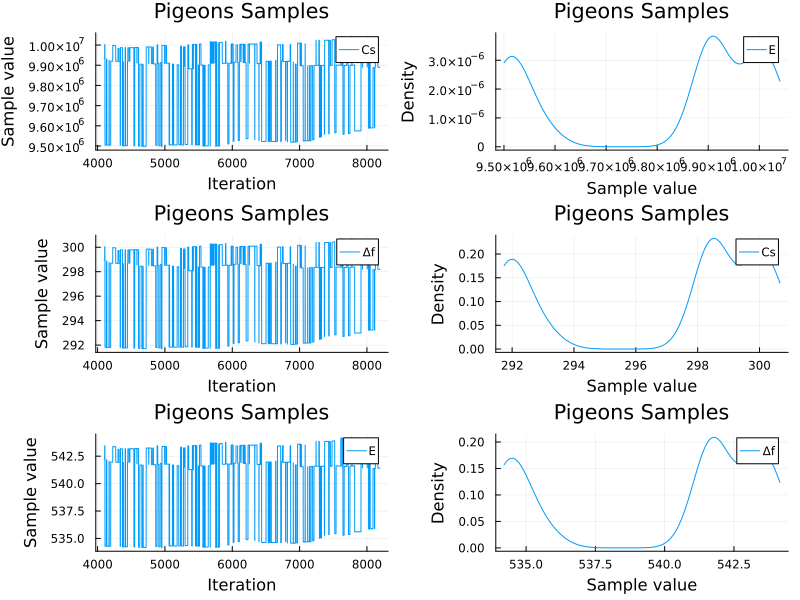

In [297]:
samples = Chains(pt)
plot(samples[end÷2:end], 
    vars = [:Cs, :E, :Δf], 
    title = "Pigeons Samples",
    xlabel = "Iteration",
    ylabel = "Parameter Value",
    label = ["Cs" "E" "Δf"],
    legend = :topright,
    layout = (3, 1),
    size = (800, 600))